<a href="https://colab.research.google.com/github/manjitullal/Lung-Diseases-Detection/blob/main/Multi_Label_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

# download data from kaggle 

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/datasets/kaggle/kaggle.json ~/.kaggle/

Mounted at /content/drive


In [3]:
# download data from kaggle 

! kaggle datasets download -d nih-chest-xrays/data

# unzip the data 

! unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_012/images/00028897_016.png  
  inflating: images_012/images/00028897_017.png  
  inflating: images_012/images/00028897_018.png  
  inflating: images_012/images/00028897_019.png  
  inflating: images_012/images/00028897_020.png  
  inflating: images_012/images/00028898_000.png  
  inflating: images_012/images/00028899_000.png  
  inflating: images_012/images/00028899_001.png  
  inflating: images_012/images/00028899_002.png  
  inflating: images_012/images/00028900_000.png  
  inflating: images_012/images/00028901_000.png  
  inflating: images_012/images/00028901_001.png  
  inflating: images_012/images/00028902_000.png  
  inflating: images_012/images/00028902_001.png  
  inflating: images_012/images/00028902_002.png  
  inflating: images_012/images/00028902_003.png  
  inflating: images_012/images/00028902_004.png  
  inflating: images_012/images/00028902_005.png  
  inflating: images_012/images/00028902_006.png  

# Efficient-net
## 14 labels excluding Hernia

In [4]:
import pandas as pd
import numpy as np
import os
from os import path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from itertools import cycle
from glob import glob
from itertools import chain

# pytorch imports
import torch
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Normalize, ToTensor

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [5]:
labels_path = '/content/Data_Entry_2017.csv'
train_path = '/content/train_val_list.txt' 
test_path = '/content/test_list.txt'

all_xray_df = pd.read_csv(labels_path)
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/content/', 'images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]

all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))


train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])

train 90817 validation 10091 test 11212


In [7]:
transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.229])
])

transform_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.229])
        ])

In [8]:
class NoneTransform(object):    
    def __call__(self, image):       
        return image

class NIHDataset:
    def __init__(
        self,
        image_paths,
        labels,
        resize,
        torch_augs=None,
        augmentations=None,
        backend="cv2",
        channel_first= True,
    ):        
        self.image_paths = image_paths        
        self.labels = labels
        self.resize = resize        
        self.torch_augs = torch_augs
        self.augmentations = augmentations
        self.backend = backend
        self.channel_first = channel_first

    def __len__(self):
        return len(self.image_paths)    

    def __getitem__(self, item):
        targets = self.labels[item]

        if self.backend == "pil":
            image = Image.open(self.image_paths[item]).convert("RGB")  
  
            if self.resize is not None:
                image = image.resize(
                    (self.resize[1], self.resize[0]), resample=Image.BILINEAR
                )
            if self.augmentations is not None:
                image = np.array(image)
                augmented = self.augmentations(image=image)
                image = augmented["image"]
                
            if self.torch_augs is not None:
                image = self.torch_augs(image)                
        
        else:
            raise Exception("Backend not implemented")
        
        if self.channel_first:
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return image, torch.tensor(np.array(targets, dtype='float'))

In [9]:
trainset = NIHDataset(train_df['path'], 
                      train_df['disease_vec'],  
                      resize= None,
                      torch_augs=transform_train,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

validset = NIHDataset(valid_df['path'], 
                      valid_df['disease_vec'],  
                      resize= None, 
                      torch_augs=transform_val,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

testset = NIHDataset(test_df['path'], 
                      test_df['disease_vec'],  
                      resize= None, 
                      torch_augs=transform_val,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

bs = 16

trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = DataLoader(validset, batch_size=bs, shuffle=True)
testloader = DataLoader(testset, batch_size=bs, shuffle=True)

In [10]:
print (len(trainloader), len(valloader), len(testloader))

5677 631 701


In [11]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=03e3e4cabf5acd49f9b93fd2919f3b442f52989d888afbd1696ddb1095580d85
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
from efficientnet_pytorch import EfficientNet

model_e = EfficientNet.from_name('efficientnet-b4')
set_parameter_requires_grad(model_e, False)
n_classes = len(all_labels)
model_e._fc = nn.Linear(1792,n_classes)
model_e.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [14]:
path = '/content/drive/MyDrive/Projects/DS5500/final/'

optimizer = torch.optim.Adam(model_e.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [15]:
def train(model, num_epochs, trainloader, valloader):  
  all_statistics = {'training':{'loss': {key+1:[] for key in range(num_epochs)}, 'accuracy': {key+1:[] for key in range(num_epochs)}}, 
                  'validation':{'loss': {key+1:[] for key in range(num_epochs)}, 'accuracy': {key+1:[] for key in range(num_epochs)}}}

  training_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
  validation_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
  for epoch in range(num_epochs):
    losses = list()
    accuracy = list()
    correct = 0

    model.train()
    for i, batch in enumerate(trainloader):
      image, label = batch
      image = image.to(device)
      label = label.to(device) 

      # 1. forward
      output = model(image)

      # 2. objective function    
      loss = criterion(output, label)                 # The output from the model will be bsx3072 hence changing the dimension of image      
    
      # 3. clean gradients 
      model.zero_grad()
    
      # 4. accumulate gradients 
      loss.backward()
    
      # 5. optimizer
      optimizer.step()
    
      # get model accuracy, convert the logit output into 1,0 and then 
      output_logits = (torch.sigmoid(output)>0.5).float()
    
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())   
      accuracy.append(correct/14)         
        
      training_statistics['loss'].append(loss.item())
      training_statistics['accuracy'].append(correct/14)
      training_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      training_statistics['logits'].append(output_logits.cpu())            
      training_statistics['label'].append(label.cpu())            
      
        
      if (i%100 == 0):
        print(f'Current training sample [{i}/{len(trainloader)}] loss: {loss.cpu().item()}')        
    
    all_statistics['training']['loss'][epoch+1].append(torch.tensor(losses).mean().item())
    all_statistics['training']['accuracy'][epoch+1].append(torch.tensor(accuracy).mean().item())

    print(f'Epoch {epoch + 1}, training loss: {torch.tensor(losses).mean():.2f}')
    print(f'Epoch {epoch + 1}, training accuracy: {torch.tensor(accuracy).mean():.2f}')
      

    model.eval()
    losses = list()
    accuracy = list()
    correct = 0

    for i, batch in enumerate(valloader):
      image, label = batch      
      image = image.to(device)
      label = label.to(device)

      # 1. forward
      with torch.no_grad():
        output = model(image)
        
      # 2. objective function
      loss = criterion(output, label)
        
      # get model accuracy, convert the logit output into 1,0 and then 
      output_logits = (torch.sigmoid(output)>0.5).float()
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())
      accuracy.append(correct/14)  
      
      validation_statistics['loss'].append(loss.item())
      validation_statistics['accuracy'].append(correct/14)
      validation_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      validation_statistics['logits'].append(output_logits.cpu())            
      validation_statistics['label'].append(label.cpu())  

    all_statistics['validation']['loss'][epoch+1].append(torch.tensor(losses).mean().item())
    all_statistics['validation']['accuracy'][epoch+1].append(torch.tensor(accuracy).mean().item())

    print(f'Epoch {epoch + 1}, validation loss: {torch.tensor(losses).mean():.2f}')
    print(f'Epoch {epoch + 1}, validation accuracy: {torch.tensor(accuracy).mean():.2f}')

  return model, all_statistics, training_statistics, validation_statistics

In [16]:
# num_epochs = 5

# model_e, all_statistics, training_statistics, validation_statistics = train(model_e, num_epochs, trainloader, valloader)

Current training sample [0/5677] loss: 0.7019357364375277
Current training sample [100/5677] loss: 0.23641712412271382
Current training sample [200/5677] loss: 0.28150449452472714
Current training sample [300/5677] loss: 0.2409730703095972
Current training sample [400/5677] loss: 0.19885255422975334
Current training sample [500/5677] loss: 0.2556816246485271
Current training sample [600/5677] loss: 0.1651863598880092
Current training sample [700/5677] loss: 0.33481938278834733
Current training sample [800/5677] loss: 0.24138139017200694
Current training sample [900/5677] loss: 0.21924882859457284
Current training sample [1000/5677] loss: 0.2423450263169278
Current training sample [1100/5677] loss: 0.19991579333561404
Current training sample [1200/5677] loss: 0.25028179329300265
Current training sample [1300/5677] loss: 0.21014563396082458
Current training sample [1400/5677] loss: 0.24104386214873685
Current training sample [1500/5677] loss: 0.2002275852927206
Current training sample [1

In [24]:
torch.save(model_e.state_dict(), path + 'Efficient-net_NIH_v2.pt')

In [16]:
path = '/content/drive/MyDrive/Projects/DS5500/final/'

from efficientnet_pytorch import EfficientNet

model_e = EfficientNet.from_name('efficientnet-b4')
set_parameter_requires_grad(model_e, False)
n_classes = len(all_labels)
model_e._fc = nn.Linear(1792,n_classes)

model_e.load_state_dict(torch.load(path + 'Efficient-net_NIH_v2.pt'))
model_e.eval()
model_e.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [17]:
def test(model, testloader):
  model.eval()
  with torch.no_grad():
    losses = list()
    accuracy = list()    
    test_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
    for batch in testloader:
      image, label = batch
      image, label = image.to(device), label.to(device)

      output = model(image)
      loss = criterion(output, label)
      
      output_logits = (torch.sigmoid(output)>0.5).float()
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())
      accuracy.append(correct/14)

      test_statistics['loss'].append(loss.item())
      test_statistics['accuracy'].append(correct/14)
      test_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      test_statistics['logits'].append(output_logits.cpu())            
      test_statistics['label'].append(label.cpu()) 

  print(f'Average test loss: {torch.tensor(losses).mean()}')
  print(f'Average test accuracy: {torch.tensor(accuracy).mean()}')
  return test_statistics

In [18]:
%%time

test_statistics = test(model_e, testloader)

Average test loss: 0.23175479471683502
Average test accuracy: 0.2119421362876892
CPU times: user 7min 23s, sys: 9.7 s, total: 7min 33s
Wall time: 4min 46s


In [19]:
y_pred = test_statistics['probability']
y_pred = torch.cat(y_pred, axis=0)

y_truelabel = test_statistics['label']
y_truelabel = torch.cat(y_truelabel, axis=0)

y_predlabel = test_statistics['logits']
y_predlabel = torch.cat(y_predlabel, axis=0)

In [22]:
n_classes = 14

def plot_roc(y_test, y_score, title):

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(12,8))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'yellow', 'gray', 'lime', 'black', 'gold', 'cyan', 'violet', 'teal'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(all_labels[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

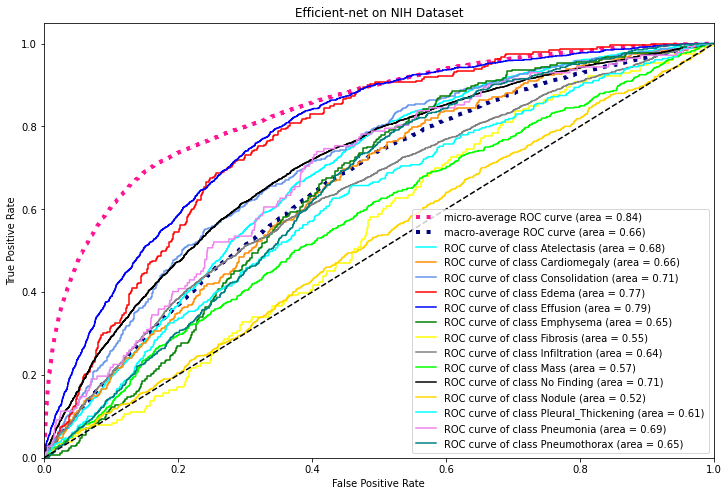

In [23]:
plot_roc(y_truelabel, y_pred, 'Efficient-net on NIH Dataset')